**S&P500 Daily Prices 1986-2018**
Description 

In [27]:
filepath = './data/spx.csv'
df = pd.read_csv(filepath)
df.head()

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


**Visualize Data** 

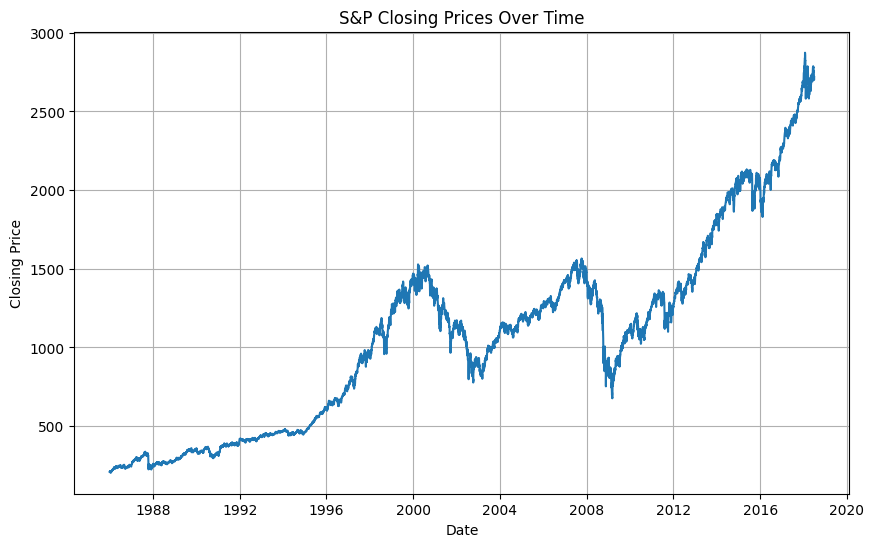

In [28]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('S&P Closing Prices Over Time')
plt.grid(True)
plt.show()

**Data Split & Normalization**
The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.
In case of multivariate data, this is done feature-wise (in other words independently for each column of the data).
Given the distribution of the data, each value in the dataset will have the mean value subtracted, and then divided by the standard deviation of the whole dataset (or feature in the multivariate case).

In [33]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 2) (410, 2)


In [34]:
from sklearn.preprocessing import StandardScaler

# Assuming 'train' and 'test' are DataFrames containing your data
scaler = StandardScaler()
scaler.fit(train[['close']])

# Transform 'close' column in train and test DataFrames
train.loc[:, 'close'] = scaler.transform(train[['close']])
test.loc[:, 'close'] = scaler.transform(test[['close']])

**Dataset**

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)
print(X_train.shape)

**Model**

In [39]:
from tensorflow import keras

# Assuming X_train.shape[1] is the number of time steps and X_train.shape[2] is the number of features
input_shape = (X_train.shape[1], X_train.shape[2])

model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.LSTM(units=64),
    keras.layers.Dropout(rate=0.2),
    keras.layers.RepeatVector(X_train.shape[1]),
    keras.layers.LSTM(units=64, return_sequences=True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2]))
])

model.compile(loss='mae', optimizer='adam')

**Training**

Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.3257 - val_loss: 0.2320
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1409 - val_loss: 0.1668
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1484 - val_loss: 0.2327
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1661 - val_loss: 0.2272
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1708 - val_loss: 0.2550
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2118 - val_loss: 0.3647
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1942 - val_loss: 0.3443
Epoch 8/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1790 - val_loss: 0.2783
Epoch 9/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2172 - val_loss: 0.1745
Epoch 10/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2067 - val_loss: 0.1569


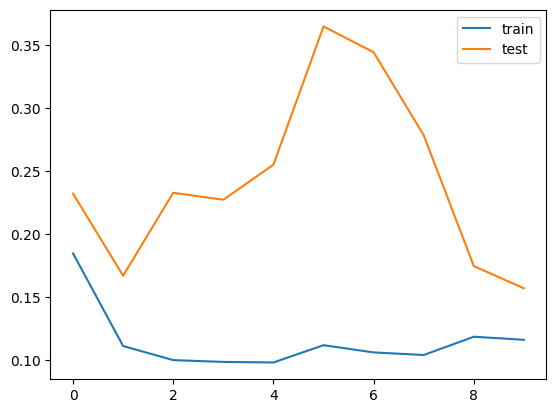

In [40]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

**Evaluation**

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


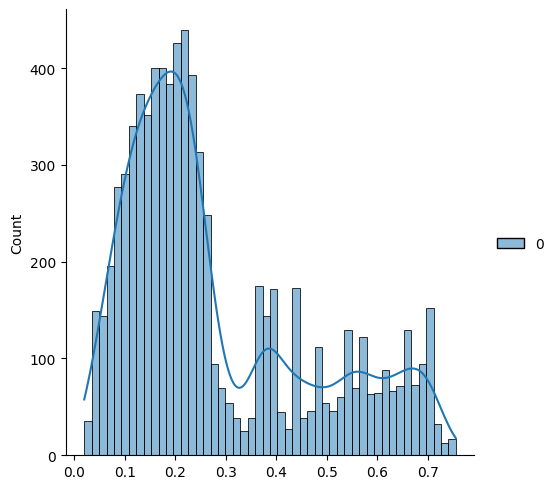

In [44]:
import seaborn as sns

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

sns.displot(train_mae_loss, bins=50, kde=True);

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


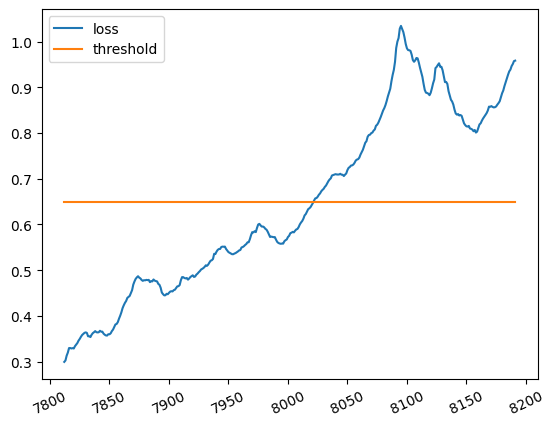

In [46]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

THRESHOLD = 0.65
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [47]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
8022,0.652400,0.65,True,2.940375
8023,0.657078,0.65,True,2.979199
8024,0.657697,0.65,True,2.963722
8025,0.660612,0.65,True,2.968286
8026,0.664969,0.65,True,2.975987


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

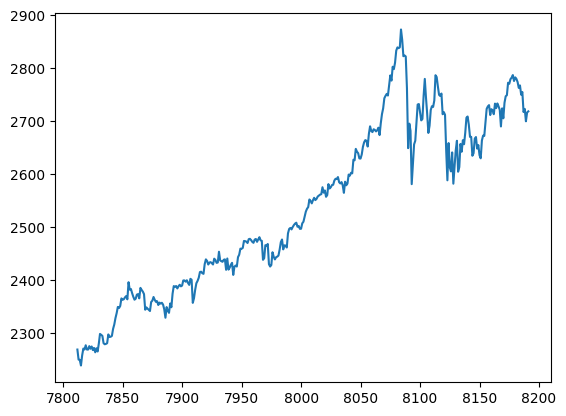

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming TIME_STEPS is defined somewhere in your code
# Convert the Series to a DataFrame with a single column
test_close_df = test[TIME_STEPS:][['close']].copy()

# Apply inverse transform to the DataFrame
test_close_df['close'] = scaler.inverse_transform(test_close_df[['close']])

# Plotting
plt.plot(test_close_df.index, test_close_df['close'], label='close price')

# Assuming anomalies is also a DataFrame
sns.scatterplot(anomalies.index, scaler.inverse_transform(anomalies[['close']]), color=sns.color_palette()[3], s=52, label='anomaly')

plt.xticks(rotation=25)
plt.legend()
plt.show()